# Solution to ADM-Homework 2
*by Vianney, Francesco, Onur Ozan and Daniel*

In [ ]:
datadir = None
# if working on colab import
try:
    from google.colab import drive
    drive.mount('/content/drive')
    datadir = "cloud"
    %run functions.py
    %run processing.py
    %run config.json
except Exception as e:
    print(e)
    datadir = "harddrive"
import functions
import processing
data_path = functions.get_from_config(datadir)
processing.initialize_processing_parameters_from_config()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# importing needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)


## Research questions [RQs]
### [RQ1]

In [5]:
# Authors

df_author = pd.read_json('lighter_authors.json',lines= True)
df_author.head()

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
1,1417316,4.02,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
2,56159,4.53,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
3,3302,3.79,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...","[40, 9416484, 12482, 3753106, 26889789, 104764...",45,12,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
4,7979,3.60,772,"[13330815, 19109351, 42306244, 72694240, 26291...","[8466327, 15739968, 22756778, 51026133, 260451...",61,14,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179


In [7]:
# Books

df_books = pd.read_json(r'lighter_books.json', lines=True, nrows=150000)

# Dropping the collumns we will not use to minimize the dataset.

columns_to_drop = ['isbn', 'isbn13', 'asin', 'edition_information', 'publisher', 'series_id', 'series_name', 'series_position', 'description', 'shelves']

df_books.drop(columns=columns_to_drop, inplace=True)
df_books = df_books[df_books['title'].notna()]
df_books = df_books[df_books['ratings_count'] >= 0]
df_books = df_books[df_books['text_reviews_count'] >= 0]

# convert 'num_pages' to integer, replacing empty strings with NaN
df_books['num_pages'] = df_books['num_pages'].replace('', np.nan).astype(float)

# filter out rows with 'num_pages' less than 0
df_books = df_books[df_books['num_pages'] >= 0]

# print information about the 'df_books' DataFrame
print(df_books.head())

   id                                              title  \
0   2  Harry Potter and the Order of the Phoenix (Har...   
1   3  Harry Potter and the Sorcerer's Stone (Harry P...   
2   4  Harry Potter and the Chamber of Secrets (Harry...   
3   5  Harry Potter and the Prisoner of Azkaban (Harr...   
4   6  Harry Potter and the Goblet of Fire (Harry Pot...   

                                             authors   author_name  author_id  \
0  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
1  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
2                                               None  J.K. Rowling    1077326   
3  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
4  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   

   work_id language  average_rating  \
0  2809203      eng            4.50   
1  4640799      eng            4.48   
2  6231171      eng            4.43

In [8]:
# Let's see which collumns we have to avoid making mistakes in the future
print(df_books.columns)

Index(['id', 'title', 'authors', 'author_name', 'author_id', 'work_id',
       'language', 'average_rating', 'rating_dist', 'ratings_count',
       'text_reviews_count', 'publication_date', 'original_publication_date',
       'format', 'image_url', 'num_pages'],
      dtype='object')


### [RQ2] 
Let’s finally dig into this vast dataset, retrieving some vital information:

1. Plot the number of books for each author in descending order.
2. Which book has the highest number of reviews?
3. Which are the top ten and ten worst books concerning the average score?
4. Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed 5. 5. throughout our virtual library.
5. How many books have more than 250 pages?
6. Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

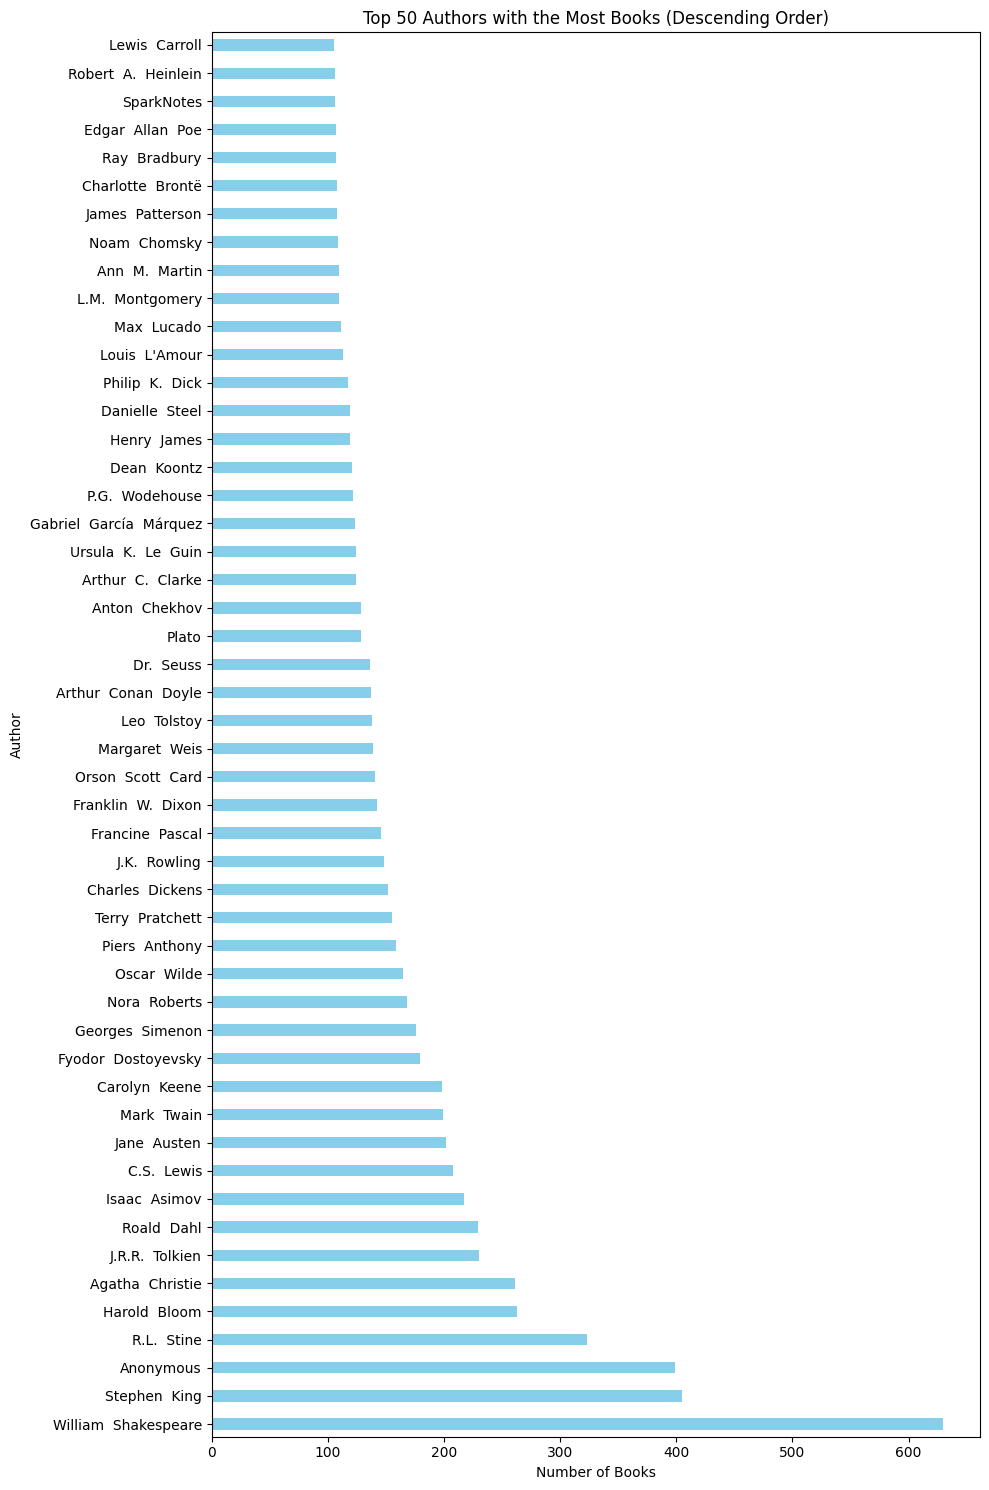

In [9]:
#RQ 2.1
author_counts = df_books['author_name'].value_counts()
# When we list the number of books by all authors, the graph becomes unreadable due to the large number of authors, so I limited the number of authors to 50. 
top_50_authors = author_counts.head(50)

top_50_authors.index = [author.replace(' ', '  ') for author in top_50_authors.index]
bar_width = 0.4 

plt.figure(figsize=(10, 15))

ax = top_50_authors.plot(kind='barh', color='skyblue', width=bar_width)
ax.set_title('Top 50 Authors with the Most Books (Descending Order)')
ax.set_xlabel('Number of Books')
ax.set_ylabel('Author')
plt.tight_layout()
plt.show()


In [10]:
#RQ 2.2

most_reviewed_books = df_books.nlargest(5, 'ratings_count')
print("Top 5 Most Reviewed Books:")
print(most_reviewed_books[['title', 'ratings_count']])

best_reviewed_books = df_books.nlargest(5, 'average_rating')
print("\nTop 5 Best Reviewed Books:")
print(best_reviewed_books[['title', 'average_rating']])

Top 5 Most Reviewed Books:
                                                   title  ratings_count
1      Harry Potter and the Sorcerer's Stone (Harry P...        7377351
2089   Harry Potter Y La Piedra Filosofal (Harry Pott...        7376804
2653            Harry Potter and the Philosopher's Stone        7376804
30984  Harry Potter and the Philosopher's Stone (Harr...        7371859
30999                 Harrius Potter et Philosophi Lapis        7371859

Top 5 Best Reviewed Books:
                                                  title  average_rating
653                                          Bernie Mac             5.0
671   Delaware 1638-1776 (Voices from Colonial America)             5.0
721   Simply Italian: 100 Easy-To-Make, Zesty, Satis...             5.0
762                                    Rudolph Giuliani             5.0
1101           Singers, Heroes, and Gods in the Odyssey             5.0


In [11]:
#RQ 2.3

# Sort the DataFrame by 'average_rating' in descending order (top 10 best)
top_10_best_books = df_books.sort_values(by='average_rating', ascending=False).head(10)

# Sort the DataFrame by 'average_rating' in ascending order (top 10 worst)
top_10_worst_books = df_books.sort_values(by='average_rating', ascending=True).head(10)

# Display the top 10 best books
print("Top 10 Best Books:")
print(top_10_best_books[['title', 'authors', 'average_rating']])

# Display the top 10 worst books
print("\nTop 10 Worst Books:")
print(top_10_worst_books[['title', 'authors', 'average_rating']])


Top 10 Best Books:
                                                    title  \
87861   Selected Works of Jawaharlal Nehru, 2nd Series...   
38593                   Mean Old Mickle & Smack-Biff-Thud   
89223                                  The Magpie's Story   
17160   Sermons, Newly Discovered (Works of Saint Augu...   
116042           Birds of Prey: A Look at Daytime Raptors   
50338      Economic Development and the Division of Labor   
129196               Yr Hen Iaith: Studies in Early Welsh   
27251   Orville And Wilbur Wright: Two Brothers, One D...   
88921                                         James Welch   
129444                         Get Sad When Somebody Dies   

                                                  authors  average_rating  
87861   [{'id': '89095', 'name': 'Jawaharlal Nehru', '...             5.0  
38593                                                None             5.0  
89223   [{'id': '35085', 'name': 'Nick Butterworth', '...             5.0  
17160

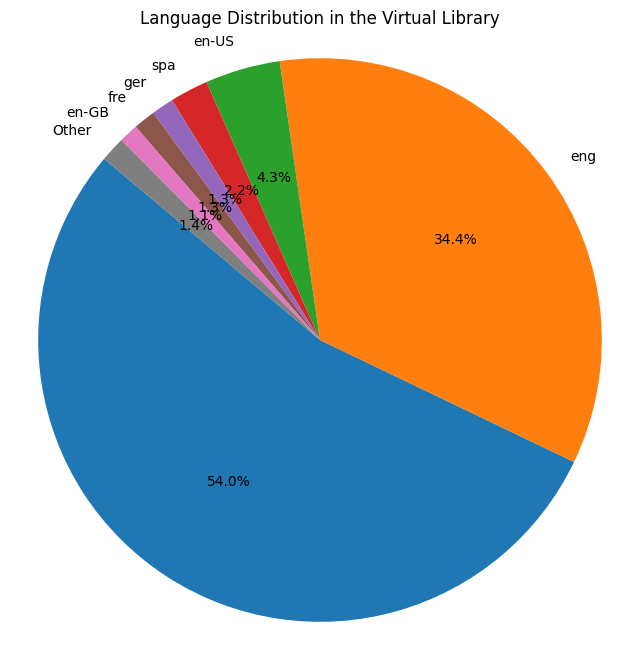

In [12]:
#RQ 2.4
language_counts = df_books['language'].value_counts()

# Calculate the total count of books
total_books = len(df_books)

# Calculate the threshold count (1% of the total)
threshold = 0.01 * total_books

# Filter out languages below the threshold and count them as "Other"
other_count = language_counts[language_counts < threshold].sum()
language_counts = language_counts[language_counts >= threshold]
language_counts['Other'] = other_count

# Create a pie chart to summarize language distribution
plt.figure(figsize=(8, 8))
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Language Distribution in the Virtual Library')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [15]:
#RQ 2.5
books_with_more_than_250_pages = df_books[df_books['num_pages'] > 250]
num_books_with_more_than_250_pages = len(books_with_more_than_250_pages)

print(f'The number of books with more than 250 pages is: {num_books_with_more_than_250_pages}')


The number of books with more than 250 pages is: 59799


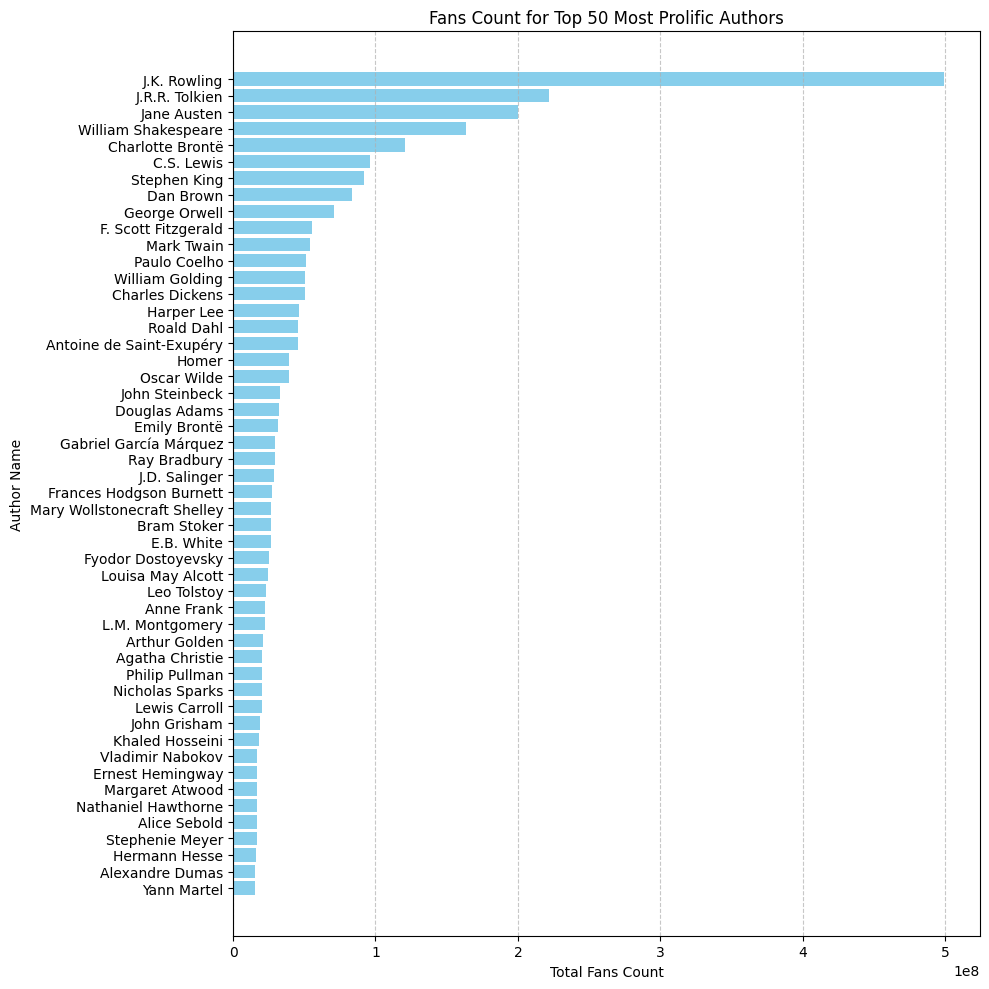

In [14]:
#RQ 2.6
author_fans_counts = df_books.groupby('author_name')['ratings_count'].sum()

# Select the top 50 authors with the most total fans
top_50_authors = author_fans_counts.nlargest(50)

# Filter the dataset to include only books by the top 50 authors
books_by_top_authors = df_books[df_books['author_name'].isin(top_50_authors.index)]

# Create a bar plot to display the author's name and their total fans count
plt.figure(figsize=(10, 10))
plt.barh(top_50_authors.index, top_50_authors.values, color='skyblue')
plt.title('Fans Count for Top 50 Most Prolific Authors')
plt.xlabel('Total Fans Count')
plt.ylabel('Author Name')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### [RQ3] 

Let’s have a historical look at the dataset!

1. Write a function that takes as input a year and returns as output the following information:

        The number of books published that year.

        The total number of pages written that year.

        The most prolific month of that year.

        The longest book written that year.

   

3. Use this function to build your data frame: the primary key will be a year, and the required information will be the attributes within the row. Finally, show the head and the tail of this new data frame considering the first ten years registered and the last ten years.

4. Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work with the one the bot gave you as an answer. Does the chatbot implementation work? Please test it out and verify the correctness of the implementation, explaining the process you followed to prove it.

In [2]:
# In order to avoid problems in terms of performance and visualization, we put range parameter in the codes. By removing this parameter, the same process can be applied for the whole dataset. 
# There is an extra work we did without range restriction below.

In [16]:
#RQ3 Human Code

# convert publication_date column to datetime format with an explicit format
df_books['publication_date'] = pd.to_datetime(df_books['publication_date'], format='%Y-%m-%d', errors='coerce')

def year_summary(year):
    
    # books published in the specified year
    year_books = df_books[df_books['publication_date'].dt.year == year]

    # the number of books published that year
    num_books_published = len(year_books)

    # number of pages written that year
    total_pages_written = year_books['num_pages'].sum()

    # group books by month and count the number of books published in each month
    month_counts = year_books['publication_date'].dt.month.value_counts()
    most_prolific_month = month_counts.idxmax()

    # longest book written that year
    longest_book = year_books.loc[year_books['num_pages'].idxmax()]

    return {
        'Year': year,
        'Number of Books Published': num_books_published,
        'Total Pages Written': total_pages_written,
        'Most Prolific Month': most_prolific_month,
        'Longest Book Title': longest_book['title'],
        'Longest Book Author': longest_book['author_name'],
        'Longest Book Pages': longest_book['num_pages']
    }

# create a DataFrame for the years you want to analyze (e.g., from 2010 to 2020)
years = list(range(2010, 2021))
year_summaries = [year_summary(year) for year in years]
year_summary_df = pd.DataFrame(year_summaries)

# show the head and tail of the DataFrame
print("Head of the DataFrame (first ten years):")
print(year_summary_df.head(10))
print("\nTail of the DataFrame (last ten years):")
print(year_summary_df.tail(10))


Head of the DataFrame (first ten years):
   Year  Number of Books Published  Total Pages Written  Most Prolific Month  \
0  2010                        324              87326.0                    1   
1  2011                        249              72994.0                   11   
2  2012                        146              42959.0                    1   
3  2013                         99              27776.0                    4   
4  2014                         88              20235.0                    1   
5  2015                        101              24700.0                    2   
6  2016                         65              18371.0                   12   
7  2017                         39              12816.0                    5   
8  2018                         44              12624.0                    2   
9  2019                         29               6629.0                    5   

                                  Longest Book Title    Longest Book Author  \

In [17]:
#RQ3 GPT Code

def year_summary(year):
    year_books = df_books[df_books['publication_date'].dt.year == year]
    num_books = len(year_books)
    total_pages = year_books['num_pages'].sum()
    month_counts = year_books['publication_date'].dt.month.value_counts()
    most_prolific_month = month_counts.idxmax()
    longest_book = year_books.loc[year_books['num_pages'].idxmax()]
    
    return year, num_books, total_pages, most_prolific_month, longest_book['title'], longest_book['author_name'], longest_book['num_pages']

years = list(range(2010, 2021))
year_summary_data = [year_summary(year) for year in years]
year_summary_df = pd.DataFrame(year_summary_data, columns=['Year', 'Number of Books Published', 'Total Pages Written', 'Most Prolific Month', 'Longest Book Title', 'Longest Book Author', 'Longest Book Pages'])

print("Head of the DataFrame (first ten years):")
print(year_summary_df.head(10))
print("\nTail of the DataFrame (last ten years):")
print(year_summary_df.tail(10))


Head of the DataFrame (first ten years):
   Year  Number of Books Published  Total Pages Written  Most Prolific Month  \
0  2010                        324              87326.0                    1   
1  2011                        249              72994.0                   11   
2  2012                        146              42959.0                    1   
3  2013                         99              27776.0                    4   
4  2014                         88              20235.0                    1   
5  2015                        101              24700.0                    2   
6  2016                         65              18371.0                   12   
7  2017                         39              12816.0                    5   
8  2018                         44              12624.0                    2   
9  2019                         29               6629.0                    5   

                                  Longest Book Title    Longest Book Author  \

In [ ]:
#Differences of these two codes.

#The first code uses a separate function year_summary to calculate the year's summary and then iterates through the list of years to collect the data.

#The second code combines the calculation and data collection directly within a list comprehension.

#The first code specifies column names when creating the DataFrame using the columns parameter.

#The second code defines column names directly within the list comprehension, which makes it slightly less readable.

In [18]:
#Something Extra

df_books['publication_date'] = pd.to_datetime(df_books['publication_date'], format='%Y-%m-%d', errors='coerce')

def year_summary(year):
    """
    Calculate book summaries for a specific year.

    Args:
        year (int): The year.

    Returns:
        dict: A dictionary containing the year's summary information.
    """
    # Books published in the specified year
    year_books = df_books[df_books['publication_date'].dt.year == year]

    # Number of books published in that year
    num_books_published = len(year_books)

    # Total pages written in that year
    total_pages_written = year_books['num_pages'].sum()

    # Count the number of books published in each month by grouping books by month
    month_counts = year_books['publication_date'].dt.month.value_counts()

    most_prolific_month = month_counts.idxmax() if not month_counts.empty else None

    # Longest book written in that year
    longest_book = year_books.loc[year_books['num_pages'].idxmax()] if not year_books.empty else None

    return {
        'Year': year,
        'Number of Books Published': num_books_published,
        'Total Pages Written': total_pages_written,
        'Most Prolific Month': most_prolific_month,
        'Longest Book Title': longest_book['title'] if longest_book is not None else None,
        'Longest Book Author': longest_book['author_name'] if longest_book is not None else None,
        'Longest Book Pages': longest_book['num_pages'] if longest_book is not None else None
    }

# Get all unique years from the DataFrame
all_years = df_books['publication_date'].dt.year.unique()

# Calculate year summaries for all years
year_summaries = [year_summary(year) for year in all_years]

# Create a DataFrame containing the summaries
year_summary_df = pd.DataFrame(year_summaries)

# Sort the DataFrame by the 'Year' column in ascending order
year_summary_df = year_summary_df.sort_values(by='Year')

# Select the newest 10 years and the oldest 10 years for display
head_table = year_summary_df.tail(10)
tail_table = year_summary_df.head(10)

# Display the newest 10 years table
print("Newest 10 Years:")
print(head_table)

# Display the oldest 10 years table
print("\nOldest 10 Years:")
print(tail_table)


Newest 10 Years:
       Year  Number of Books Published  Total Pages Written  \
45   2013.0                         99              27776.0   
42   2014.0                         88              20235.0   
51   2015.0                        101              24700.0   
72   2016.0                         65              18371.0   
71   2017.0                         39              12816.0   
81   2018.0                         44              12624.0   
48   2019.0                         29               6629.0   
79   2020.0                         22               7347.0   
104  2021.0                          2                772.0   
0       NaN                          0                  0.0   

     Most Prolific Month                                 Longest Book Title  \
45                   4.0       Chess: 5334 Problems, Combinations and Games   
42                   1.0  Business Cycles: A Theoretical, Historical, an...   
51                   2.0    The History of the Russi

### [RQ7]
Estimating probabilities is a core skill for a data scientist: show us your best!

1. Estimate the probability that a book has over 30% of the ratings above 4.
2. Estimate the probability that an author publishes a new book within two years from its last work.
3. In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.
4. Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

#### ad 1.
Estimate the probability that a book has over 30% of the ratings above 4.

After inspecting the .json-file "lighter_authors" we decided to use the attribute "rate_dist".
First we took a look at the format of this attribute and examined its general structure is

'rating_dist': '5:1674064|4:664833|3:231195|2:41699|1:16215|total:2628006'

Just with different numbers, we build our functions to process this information as the following code shows:

In [ ]:
books_with_30Percent_of_ratings_above_4, books_with_at_least_one_rating = processing.answer_rq_7_1(data_path)

The process lasted approximately 697.38 seconds.
We have found 3998205 books with 30 Percent of ratings above 4
We have found 6017150 books with at least one rating
The share of books with 30Percent of ratings above 4 is approximately:  0.6645
The process lasted approximately 697.38 seconds.


### ad 2.
Estimate the probability that an author publishes a new book within two years from its last work.

In [ ]:
results = processing.answer_rq_7_2(data_path)

0.5201 is the probability that an author publishes a book within 2 years
The process lasted approximately 766.49 seconds.


### ad 3. & 4.
3. In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.
4. Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

In [ ]:
worst_book_ids_of_all_time_set = processing.get_worst_book_ids_of_all_time(data_path)
contingency_table = processing.get_contingency_table_for_rq_7_3(data_path, worst_book_ids_of_all_time_set)
print("the contingency table looks like:")
contingency_table

The process lasted approximately 61.91 seconds.
The process lasted approximately 710.96 seconds.
the contingency table looks like:


gt700,False,True
oneOftheWorst,,
False,3811564,110900
True,5503,220


In [ ]:
res = processing.answer_rq_7_3(contingency_table)

Now we can provide the answer to 3.
by computing the ratio of the entry for "gt700 and oneOftheWorst", which is  220 ,
divided by the number of books with over 700 pages, which is 5723 .
This yields a probability of approximately: 0.0384


The fisher test is an excat hypothesis test to check independence of two binary features like given in 4.

In [ ]:
# now performing the fisher test for answering independency
pval = processing.perform_fisher_test_and_interprete(contingency_table, alpha = 0.05)

assuming a test-level of alpha = 0.05
Since the pvalue is approximately 0.000011 , i.e. less than or equal to alpha, 
there's significance for dependence.


### [RQ8]
Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

1. Can you demonstrate that readers usually rate the longest books as the worst?
2. Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?
3. About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.
4. It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.
5. Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

#### ad 1.
Can you demonstrate that readers usually rate the longest books as the worst?

/content/processing.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk.loc[:,'ratings_count'] = pd.to_numeric(chunk.loc[:,'num_pages'], errors='coerce')
/content/processing.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk.loc[:,'ratings_count'] = pd.to_numeric(chunk.loc[:,'num_pages'], errors='coerce')
/content/processing.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

The process lasted approximately 576.00 seconds.


<Axes: xlabel='log10(num_pages)', ylabel='average_rating'>

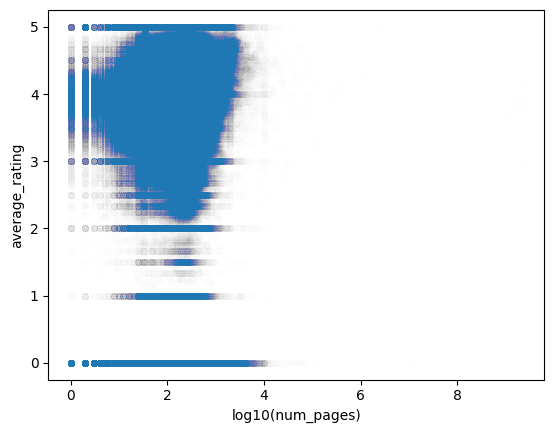

In [ ]:
books_df = processing.answer_rq_8_1(data_path)
books_df.plot.scatter(y='average_rating', x='log10(num_pages)', alpha = 0.002)


The scatterplot shows rather the opposite. Starting from 10^2.5 pages the average ratings are increasing with increasing number of pages and concentrating around 4.5.

Considering only the books with up to 10^2.5 pages, we see that the variance in the average rating increases and the mean seems to decrease.

#### ad 2.
Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?

After removing the books where no language is given we group the books by english or non-english. When done this we perform a Kolmogorov-Smirnov-Test to compare the distribution of their average-rate (:=average-ratings).

We divided them into english, non-english and no-languages. The first and the latter we defined explicitly the one in the middle is defined to be the rest.

In [ ]:
english_languages = {'en',
 'en-CA',
 'en-GB',
 'en-IN',
 'en-US',
 'eng',
 'enm'}
no_languages = {'',
 '--',
 'Select...',}

In [ ]:
books_df, grouped_df = processing.get_eng_vs_non_eng(data_path, no_languages)
grouped_df

/content/processing.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['ratings_count'] = pd.to_numeric(chunk['ratings_count'], errors='coerce')
/content/processing.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['ratings_count'] = pd.to_numeric(chunk['ratings_count'], errors='coerce')
/content/processing.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

The process lasted approximately 626.25 seconds.


,average_rating
en,
False,"[3.74, 3.93, 3.86, 3.99, 3.9, 3.28000000000000..."
True,"[4.5, 4.48, 4.43, 4.57, 4.5600000000000005, 4...."


In [ ]:
# now performing the kolmogorov-smirnov-test to check equality of the two distributions:
pval = processing.perform_ks2s_test_and_interprete(grouped_df.loc[False,'average_rating'], grouped_df.loc[True,'average_rating'], alpha=0.05)

assuming a test-level of alpha = 0.05
Since the pvalue is approximately 0.000000 , i.e. less than or equal to alpha, 
there's significance for a difference in the analyzed distributions.


#### ad 3.
About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.

Next we provide some (helpful) statistics and a boxplot. First we want to describe a boxplot as it is created by the method we use:

"The box extends from the first quartile (Q1) to the third quartile (Q3) of the data, with a line at the median. The whiskers extend from the box to the farthest data point lying within 1.5x the inter-quartile range (IQR) from the box. Flier points are those past the end of the whiskers."

source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

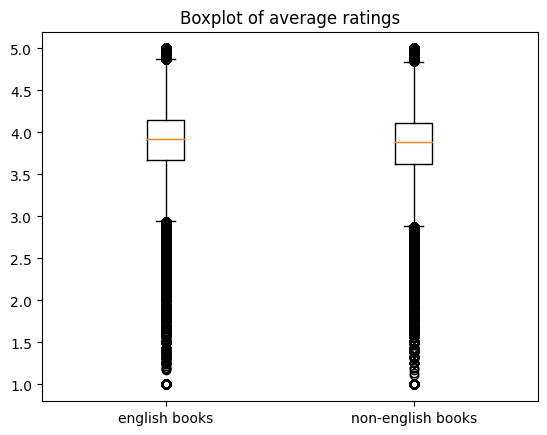

,ratings_count,average_rating
count,2.559436e+06,2.559436e+06
mean,3.659237e+04,3.870687e+00
std,2.339213e+05,4.700350e-01
min,1.000000e+00,1.000000e+00
25%,1.900000e+01,3.650000e+00
50%,2.100000e+02,3.910000e+00
75%,3.120250e+03,4.130000e+00
max,7.400639e+06,5.000000e+00


In [ ]:
from matplotlib import pyplot as plt
plt.title("Boxplot of average ratings")
plt.boxplot([grouped_df.loc[True,'average_rating'], grouped_df.loc[False,'average_rating']], labels =["english books","non-english books"])
plt.show()
books_df.describe()

Next we see the **mode** of ratings_count, average_rating, language and en."
The mode is probably only useful for "langauge" and "en" since these are non-metric, even categorical.


In [ ]:
books_df.mode()


,ratings_count,average_rating,language,en
0,1,4.0,eng,True


#### ad 4.
It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.

The process lasted approximately 22.04 seconds.
We consider the rooted dataset since here the impact of outliers is lowered.
slope is 1.0064483337654362
intercept is 218.6714909962816
R-squared-Coefficient is 0.48201227257060164
Since the slope is significantly greater than zero 
we see that the more fans an author has the more text_reviews he has. 
Hence we can refuse the stated claim that fans of authors with more fans would be lazier. 
The R-squared-Coefficient is with approximately 0.48
is low. Hence the model does explain only little of the seen variance.


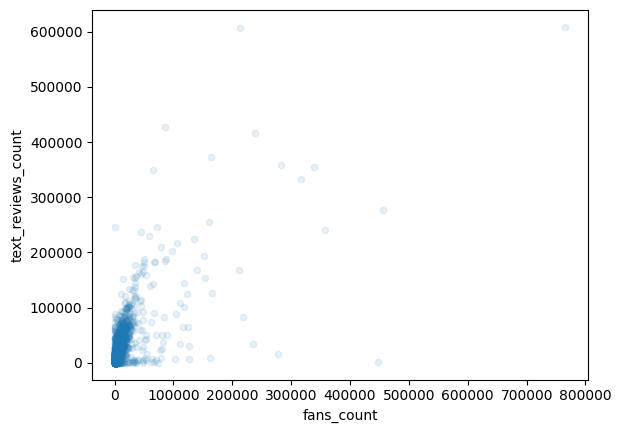

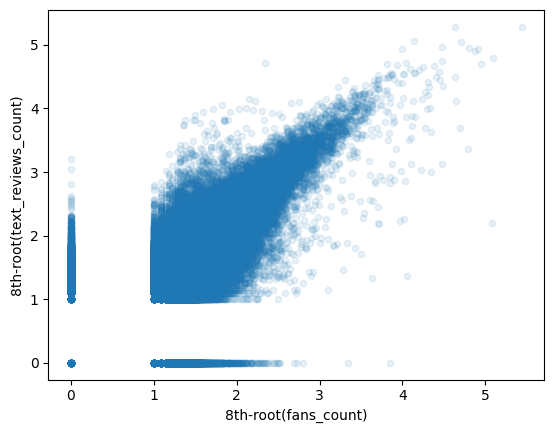

In [ ]:
books_df = None # to free some memory
authors_df = processing.get_data_on_lazyness(data_path)
authors_df.plot.scatter(x='fans_count', y='text_reviews_count', alpha = 0.1)
authors_df.plot.scatter(x='8th-root(fans_count)', y='8th-root(text_reviews_count)', alpha = 0.1)
model, score = processing.perform_lin_regression(authors_df, 'fans_count', 'text_reviews_count'  )
print('We consider the rooted dataset since here the impact of outliers is lowered.')
processing.interprete_lin_regression(model,score)

#### ad 5.
Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

##### Hypothesis testing:
The alternative is (if possible) the claim we want to confirm. However sometimes it is not possible to choose what we want to claim as the alternative. For example if we are testing "theta $=$ 0" vs. "theta $\neq$ 0" often it is only possible to choose "theta==0" as the hypothesis.

Whenever we test hypotheses we need to determine a significance level, often called alpha, which determines the highest acceptable error of 1st kind, to determine if there's evidence for the alternative or not.

###### (non-)parametric tests:
Parametric tests assume that the distribution of data is known up to a paramter $\theta \in \mathbb{R}^d$ for some $d \in \mathbb{N}$. Given that we know the distribution (with high probability) we should use these since they are more appropriate for our data.

However if we don't know the distribution we should go for nonparametric tests, since these do not make assumptions on the distribution of the data. With less requirements for a tests one naturally gets less out of it, but few is better than nothing or something wrong.

###### Some useful tests are...
- fisher and chi-square for independence of binary resp. categorical variables
- kolmogorov-smirnov or mann-whitney-u to compare two unknown distributions
- regression tests
  - (multiple) linear regression
  - logistic regression
  - polynomial regression


## Command Line Question
1. Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]
2. Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.

In [ ]:
# commandline_original.sh
# Human Code

#!/bin/bash

data="series.json"

top_count=5

series=()
while read -r line; do
    id=$(echo "$line" | jq -r '.id')
    title=$(echo "$line" | jq -r '.title')
    book_count=$(echo "$line" | jq -r '.works | map(.books_count | tonumber) | add')

    if [ -n "$id" ] && [ -n "$title" ] && [ -n "$book_count" ]; then
        series+=("$id|$title|$book_count")
    fi
done < "$data"

sorted_series=($(echo "${series[@]}" | tr ' ' '\n' | sort -t "|" -k3,3nr | head -n $top_count))

echo "id    title                                total_books_count"

for line in "${sorted_series[@]}"; do
    IFS="|" read -r id title book_count <<< "$line"
    printf "%-6s%-35s%-6s\n" "$id" "$title" "$book_count"
done


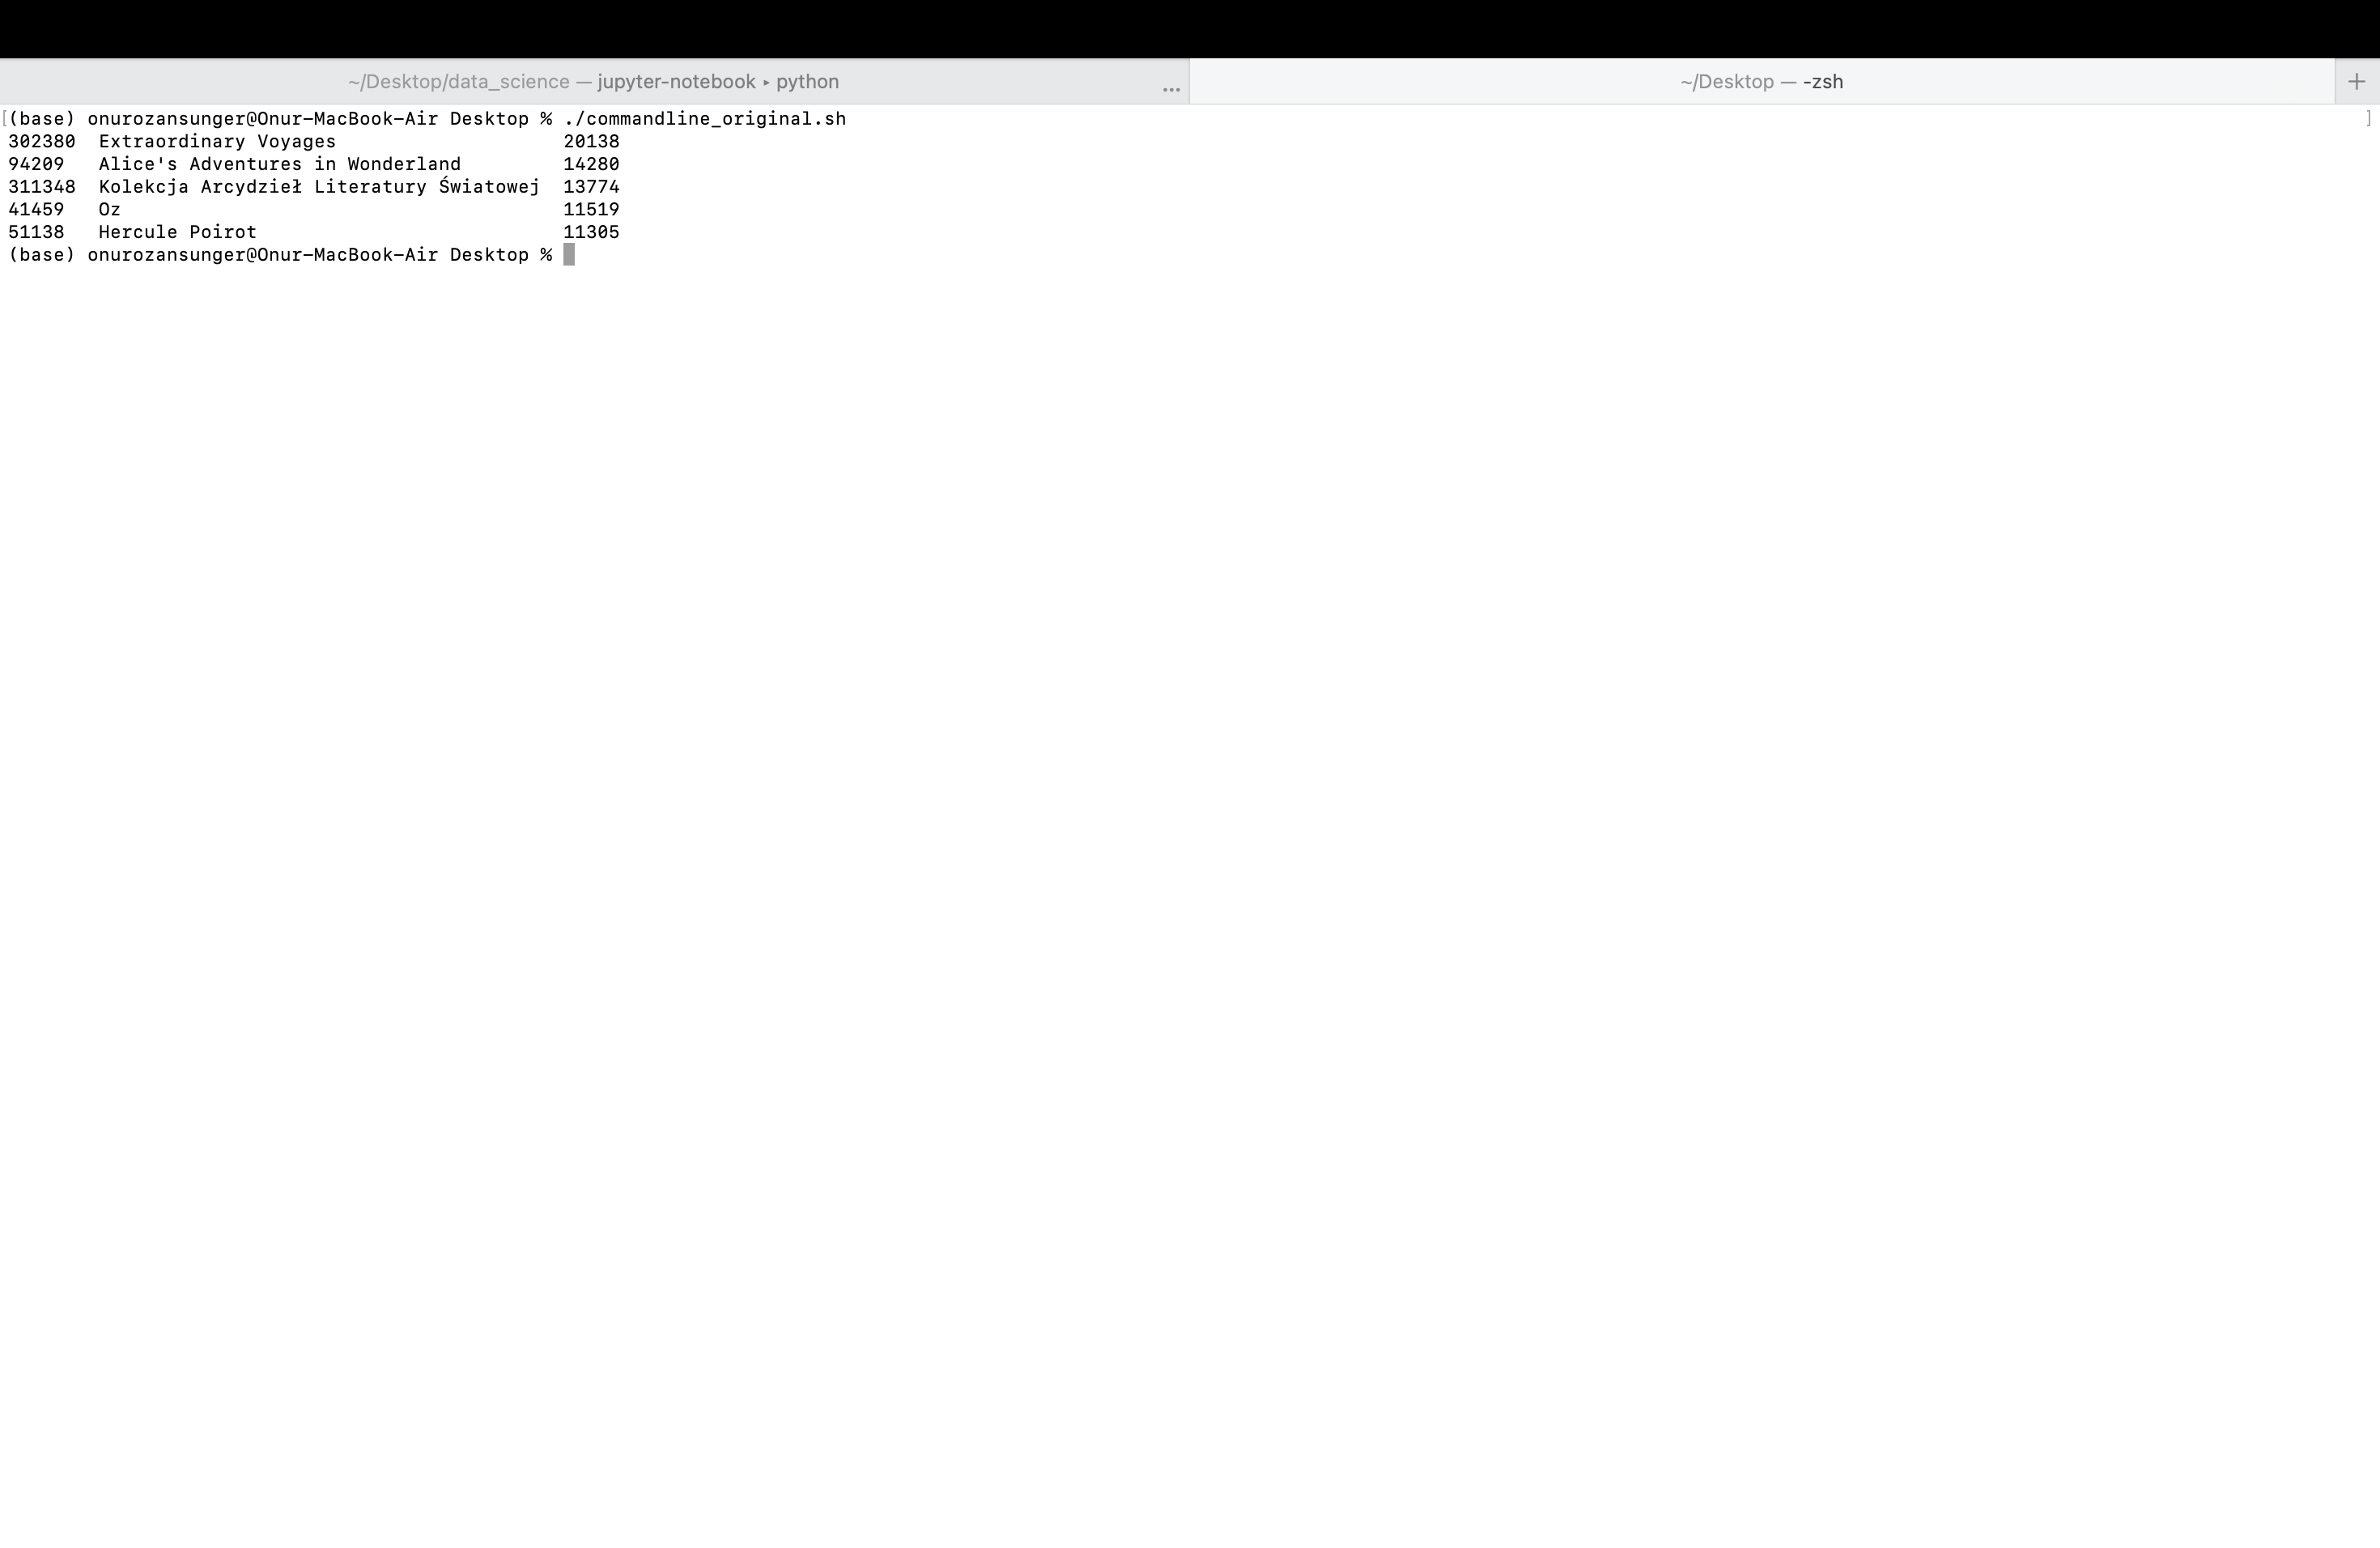

In [ ]:
# commandline_LLM.sh
# GPT Code

#!/bin/bash
data="series.json"
jq -r '.id as $id | .title as $title | (.works | map(.books_count | tonumber) | add) as $total_books_count | "\($id)\t\($title)\t\($total_books_count)"' "$data" | sort -t$'\t' -k3,3nr | head -n 5 | column -t -s $'\t'

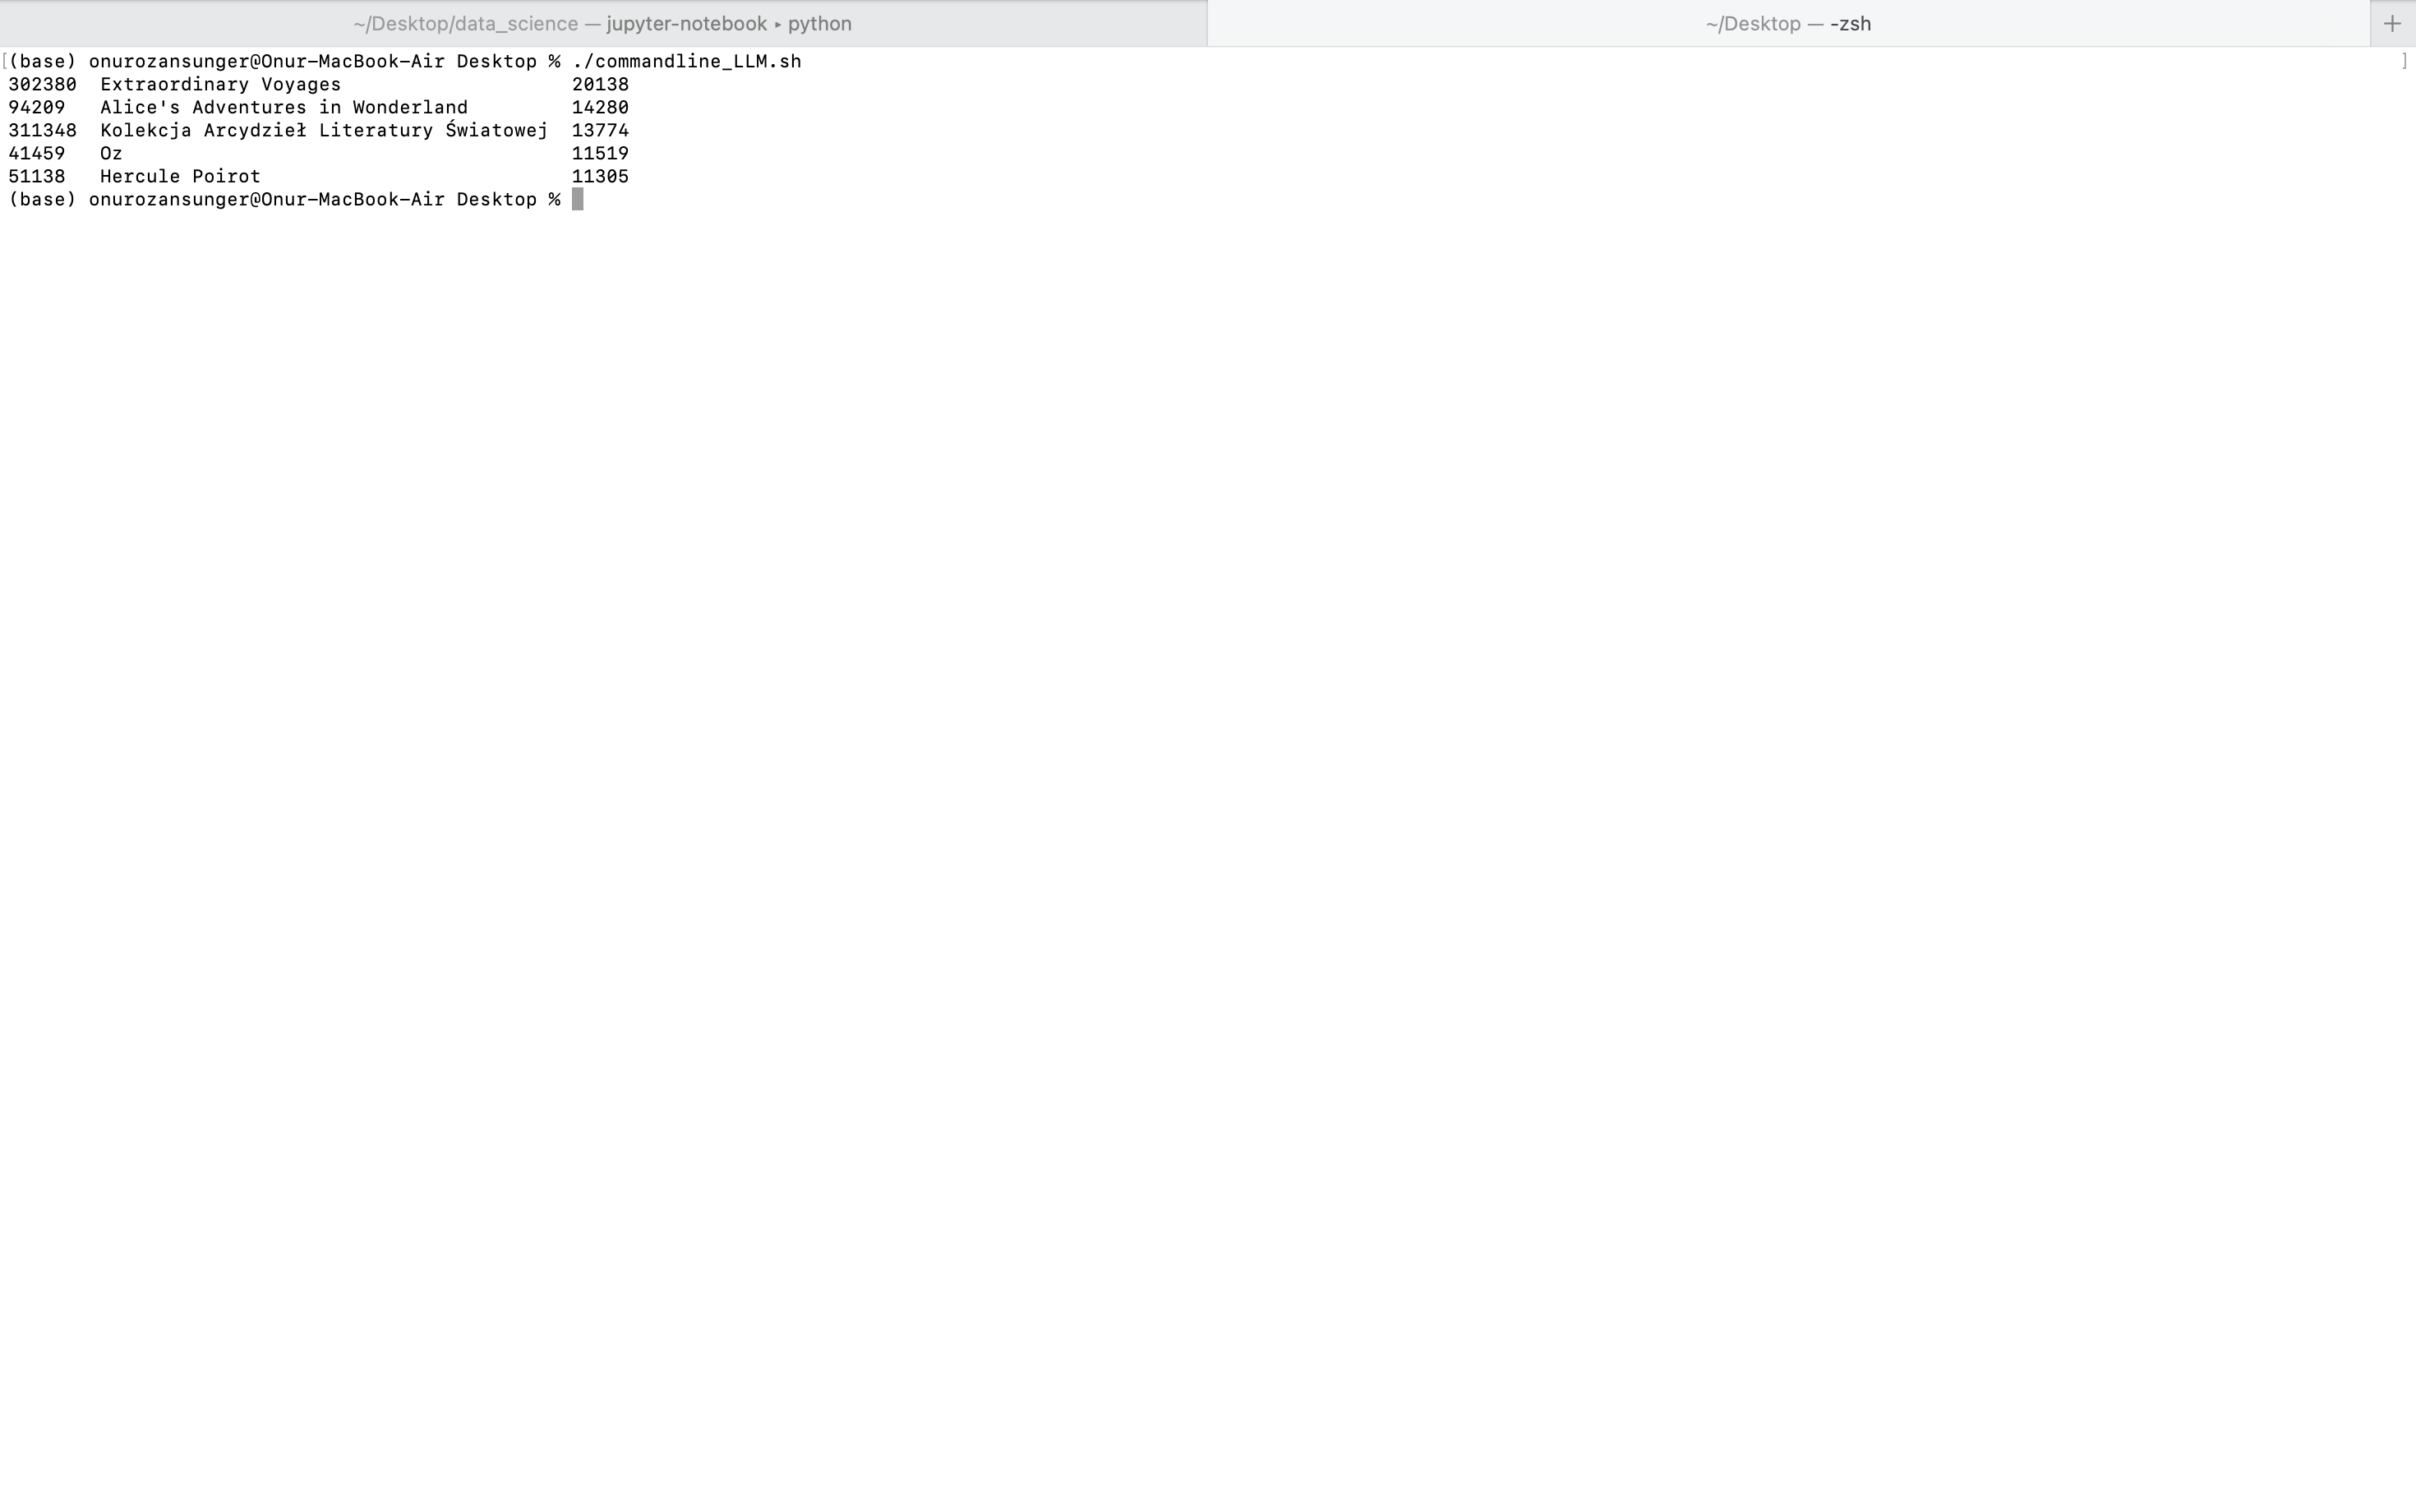

## Algorithmic Question
1. Implement a code to answer the problem on https://github.com/Sapienza-University-Rome/ADM/tree/master/2023/Homework_2 . 
2. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Do you believe this is correct? How can you double-check it? Elaborate about your answer.
3. Is the algorithm proposed in (1.) the optimal one to produce the required output? If not, can you suggest a better algorithm to perform the same task?

### ad 1.
We solve the task by implementing a dictionary. The dictionary's keys are the book IDs. The value of each book ID represents its position.

If the boss asks for a book by "? N" we can deliver the minimal number of books to be popped in constant time (calculation follows in 2.).

The time to create the shelf is of course O(n). But this is the time which is needed for the input. Hence irrelevant.

Further we supply a method to visualize the library in an ordinary list.

In [ ]:
# visualization of the shelf
visualizeIt = False
def visualizeShelf(my_dict):
    """
    takes a dictionary consisting of integer keys and integers values.
    Returns a list of the keys where the keys are sorted by their values.
    """
    return [ k for k,v in sorted(my_dict.items(), key=lambda x: x[1])]

In [ ]:
n = int(input())
shelf = {}
leftmost = -1 # next free position on the left
rightmost = 0 # next free position on the right
for _ in range(n):
    command, book_id = input().split()
    if command == "L":
        shelf[int(book_id)]=leftmost
        leftmost -= 1
        continue
    if command == "R":
        shelf[int(book_id)]=rightmost
        rightmost += 1
        continue
    if command == "?":
        if visualizeIt:
            print('current shelf looks like:', visualizeShelf(shelf))
        print(min( shelf[int(book_id)] - (leftmost + 1) , (rightmost - 1) - shelf[int(book_id)]))




1
1


#### Ad 2.
*We are considering "Is this correct?" referring to the answer of ChatGPT and not the code itself. Furhter we are considering visualizeIt to be **false**.*

**Question asked to ChatGPT:**

Estimate the time complexity of the following code, especially for the "?"-Command and in the "?"-case respectively: [above code inserted]

**Answer by ChatGPT:**

The time complexity of the provided code is as follows:

- For the "L" and "R" commands, the time complexity is **O(1)**. This is because adding an element to a dictionary in Python is a constant time operation.

- For the "?" command, the time complexity is also **O(1)**. This is because looking up an element in a Python dictionary is a constant time operation, and the mathematical operations (like subtraction and the min function) are also constant time operations.

So overall, the time complexity of the code is **O(n)**, where **n** is the number of commands to be executed. This is due to the fact that each command is executed once in a for loop. Each command has a constant time complexity, so the total time complexity is linear with respect to the number of commands.

**Resumé**

The answer given by ChatGPT is correct. We can calculate it:
Before the first (and only) loop there are only constant-time-operations
- declaring variables, 
- initiating an empty dictionary, 
- taking one line of input.
In the first (and only) loop there are again only constant-time-operations:
- comparing two characters and evaluating the truth value,
- writing a value and a key to a dictionary, 
- updating integers,
- performing a "continue" (i.e. jump in the code),
- looking up a value in dictionary (! this is done by hashing and hence constant!)
- adding and substracting a finite and constant number of integers
- calculating the minimum of a finite and constant number of integers

Since every computation inside the loop needs only constant time and there are finitely many computations inside the loop, the loop itself has time-complexity O(n), where n is the number of iterations of the loop or the number of incoming commands, respectively.
Since before the loop there are only constant-timte-computations and there is no code after the loop we have a time-complexity for the whole code of O(n).

As said above by hashing it is possible to access a value of a given key in a dictionary in constant time. Hence the ?-command is performed in constant time. 








### ad 3.
**Concerning the whole Code:**

Given that the way the input is supplied is fixed the time complexity of the whole code is optimal, since its time-complexity is determined by the way the input is supplied.
If the way the input is supplied is not fixed one could alternatively think about providing the input in one line. Then one could split, which can be done faster than in O(n). For example consider a string with n entries, each separated by a comma. Then similiar to a binary-tree it could be split easily (parallely) in O(log(n)). If the input could be directly transformed into a dictionary even faster input is thinkable.

**Concerning the "?"-command**

By the choice of our model of time-complexity (where reading an integer takes constant time (as well as writing an integer)), performing the "?"-command in O(1) is optimal.



